In [4]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

import dolfinx.plot as plot
from dolfinx.io import gmshio, XDMFFile
from dolfinx.fem import Function, FunctionSpace, VectorFunctionSpace
from dolfinx.mesh import (CellType, compute_midpoints, create_unit_cube,
                          create_unit_square, meshtags)
from dolfinx.geometry import (BoundingBoxTree, compute_colliding_cells,
                              compute_collisions)
from ufl import FiniteElement, VectorElement

from mpi4py import MPI
from petsc4py import PETSc

Info    : Reading '../mesh/branson-refined.msh'...
Info    : 11 entities
Info    : 6610 nodes
Info    : 3362 elements
Info    : Done reading '../mesh/branson-refined.msh'


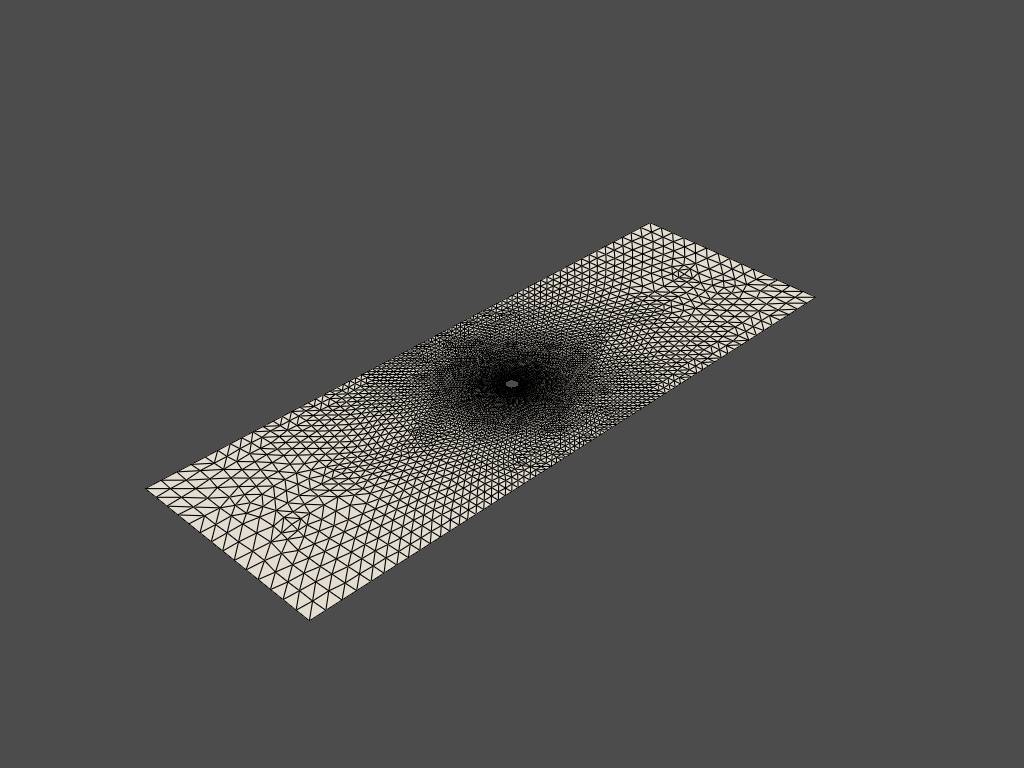

In [5]:
def u_fcn(x):
    return np.stack((np.zeros(x.shape[1]), x[0]**2))

gdim = 2
# msh = create_unit_square(MPI.COMM_WORLD, 5, 5)
msh, _, ft = gmshio.read_from_msh(
    "../mesh/branson-refined.msh", MPI.COMM_WORLD)

plotter = pv.Plotter()
cells, types, x = plot.create_vtk_mesh(msh)
grid = pv.UnstructuredGrid(cells, types, x)
plotter.add_mesh(grid, show_edges=True)
plotter.show(jupyter_backend="static")

(6610, 3)
(13220,)


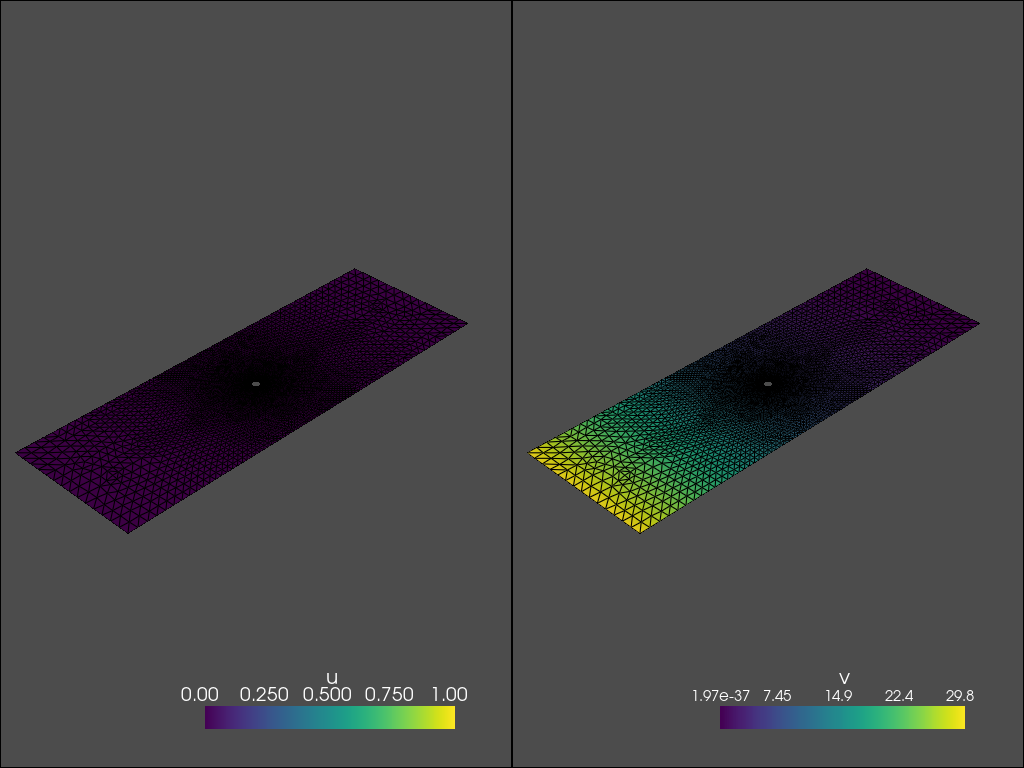

In [6]:
plotter = pv.Plotter(shape=(1, 2))
V0 = VectorFunctionSpace(msh, ("Lagrange", 2), dim=2)
u0 = Function(V0, dtype=np.float64)
u0.interpolate(u_fcn)

# Create a second grid, whose geometry and topology is based on the
# output function space
cells, cell_types, x = plot.create_vtk_mesh(V0)
grid = pv.UnstructuredGrid(cells, cell_types, x)

print(V0.tabulate_dof_coordinates().shape)
print(u0.x.array.shape)

values = np.zeros((x.shape[0], 2), dtype=np.float64)
values[:, :msh.topology.dim] = u0.x.array.reshape(x.shape[0], msh.topology.dim).real
grid.point_data["u"] = values

plotter.subplot(0, 0)
plotter.add_mesh(grid.copy(), component=0, show_edges=True, show_scalar_bar=True)
plotter.subplot(0, 1)
plotter.add_mesh(grid.copy(), component=1, show_edges=True, show_scalar_bar=False)
plotter.add_scalar_bar("v")
plotter.link_views()
plotter.camera_position = 'iso'
# plotter.background_color = 'white'
plotter.show(jupyter_backend="static")

In [7]:
plotter = pv.Plotter(shape=(1, 2))

V0 = VectorFunctionSpace(msh, ("Lagrange", 2), dim=2)
u0 = Function(V0, dtype=np.float64)

x_eval = [2.9, 0.925, 0]
tree = BoundingBoxTree(msh, dim=2)
cell_candidates = compute_collisions(tree, x_eval)
cell = compute_colliding_cells(msh, cell_candidates, x_eval)
first_cell = cell[0]

viewer = PETSc.Viewer().createMPIIO('../outputs/branson-testing-u.dat', 'r', MPI.COMM_WORLD)
u0.vector.load(viewer)
print(u0.eval(x_eval, first_cell))

n_load = 1
u_eval_loaded = np.zeros((n_load, ))
for i in range(n_load):
    u0.vector.load(viewer)
    u0.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    u_eval_loaded[i] = u0.eval(x_eval, first_cell)[0]

[ 8.73460064e-03 -4.10511740e-05]


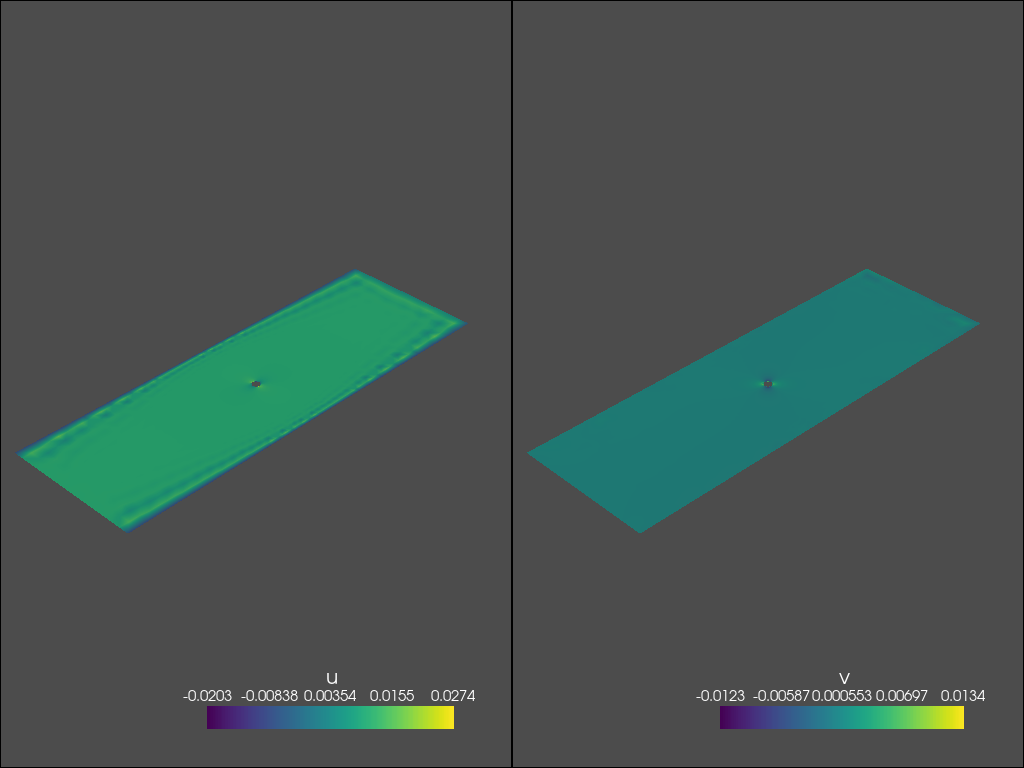

In [8]:
values = np.zeros((x.shape[0], 2), dtype=np.float64)
values[:, :msh.topology.dim] = u0.x.array.reshape(x.shape[0], msh.topology.dim).real
grid.point_data["u"] = values

plotter.subplot(0, 0)
plotter.add_mesh(grid.copy(), component=0, show_edges=False, show_scalar_bar=True)
plotter.subplot(0, 1)
plotter.add_mesh(grid.copy(), component=1, show_edges=False, show_scalar_bar=False)
plotter.add_scalar_bar("v")
plotter.link_views()
plotter.camera_position = "iso"
# plotter.background_color = 'white'
plotter.show(jupyter_backend="static")

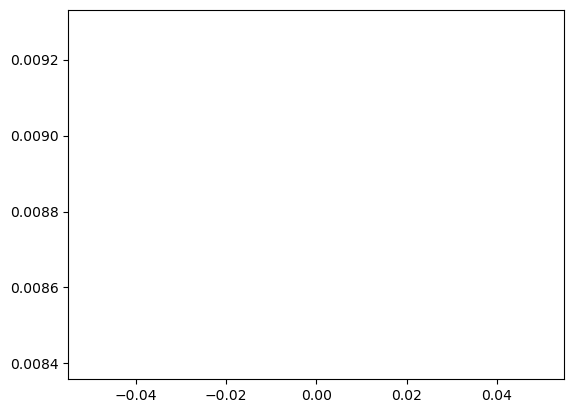

In [9]:
plt.plot(u_eval_loaded)